In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (accuracy_score, precision_score, recall_score, 
                             f1_score, confusion_matrix, classification_report,
                             roc_curve, roc_auc_score, precision_recall_curve,
                             average_precision_score)

plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")


In [2]:
import pandas as pd
df = pd.read_csv('diabetes.csv')

print(" Data Information:")
print(f"Data size: {df.shape}")
print(f"\nClass distribution:\n{df['Outcome'].value_counts()}")
print(f"\nPositive class percentage: {(df['Outcome'].mean()*100):.1f}%")


 Data Information:
Data size: (768, 9)

Class distribution:
Outcome
0    500
1    268
Name: count, dtype: int64

Positive class percentage: 34.9%


In [3]:
zero_columns = ['Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI']
for col in zero_columns:
    df[col] = df[col].replace(0, df[col].median())


In [6]:
X = df.drop('Outcome', axis=1)
y = df['Outcome']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


In [7]:
model = LogisticRegression(
    random_state=42,
    max_iter=1000,
    class_weight='balanced',
    solver='liblinear'
)
model.fit(X_train_scaled, y_train)


,"penalty penalty: {'l1', 'l2', 'elasticnet', None}, default='l2'Specify the norm of the penalty:- `None`: no penalty is added;- `'l2'`: add a L2 penalty term and it is the default choice;- `'l1'`: add a L1 penalty term;- `'elasticnet'`: both L1 and L2 penalty terms are added... warning:: Some penalties may not work with some solvers. See the parameter `solver` below, to know the compatibility between the penalty and solver... versionadded:: 0.19 l1 penalty with SAGA solver (allowing 'multinomial' + L1).. deprecated:: 1.8 `penalty` was deprecated in version 1.8 and will be removed in 1.10. Use `l1_ratio` instead. `l1_ratio=0` for `penalty='l2'`, `l1_ratio=1` for `penalty='l1'` and `l1_ratio` set to any float between 0 and 1 for `'penalty='elasticnet'`.",'deprecated'
,"C C: float, default=1.0Inverse of regularization strength; must be a positive float.Like in support vector machines, smaller values specify strongerregularization. `C=np.inf` results in unpenalized logistic regression.For a visual example on the effect of tuning the `C` parameterwith an L1 penalty, see::ref:`sphx_glr_auto_examples_linear_model_plot_logistic_path.py`.",1.0
,"l1_ratio l1_ratio: float, default=0.0The Elastic-Net mixing parameter, with `0 <= l1_ratio <= 1`. Setting`l1_ratio=1` gives a pure L1-penalty, setting `l1_ratio=0` a pure L2-penalty.Any value between 0 and 1 gives an Elastic-Net penalty of the form`l1_ratio * L1 + (1 - l1_ratio) * L2`... warning:: Certain values of `l1_ratio`, i.e. some penalties, may not work with some solvers. See the parameter `solver` below, to know the compatibility between the penalty and solver... versionchanged:: 1.8 Default value changed from None to 0.0... deprecated:: 1.8 `None` is deprecated and will be removed in version 1.10. Always use `l1_ratio` to specify the penalty type.",0.0
,"dual dual: bool, default=FalseDual (constrained) or primal (regularized, see also:ref:`this equation `) formulation. Dual formulationis only implemented for l2 penalty with liblinear solver. Prefer `dual=False`when n_samples > n_features.",False
,"tol tol: float, default=1e-4Tolerance for stopping criteria.",0.0001
,"fit_intercept fit_intercept: bool, default=TrueSpecifies if a constant (a.k.a. bias or intercept) should beadded to the decision function.",True
,"intercept_scaling intercept_scaling: float, default=1Useful only when the solver `liblinear` is usedand `self.fit_intercept` is set to `True`. In this case, `x` becomes`[x, self.intercept_scaling]`,i.e. a ""synthetic"" feature with constant value equal to`intercept_scaling` is appended to the instance vector.The intercept becomes``intercept_scaling * synthetic_feature_weight``... note:: The synthetic feature weight is subject to L1 or L2 regularization as all other features. To lessen the effect of regularization on synthetic feature weight (and therefore on the intercept) `intercept_scaling` has to be increased.",1
,"class_weight class_weight: dict or 'balanced', default=NoneWeights associated with classes in the form ``{class_label: weight}``.If not given, all classes are supposed to have weight one.The ""balanced"" mode uses the values of y to automatically adjustweights inversely proportional to class frequencies in the input dataas ``n_samples / (n_classes * np.bincount(y))``.Note that these weights will be multiplied with sample_weight (passedthrough the fit method) if sample_weight is specified... versionadded:: 0.17 *class_weight='balanced'*",'balanced'
,"random_state random_state: int, RandomState instance, default=NoneUsed when ``solver`` == 'sag', 'saga' or 'liblinear' to shuffle thedata. See :term:`Glossary ` for details.",42
,"solver solver: {'lbfgs', 'liblinear', 'newton-cg', 'newton-cholesky', 'sag', 'saga'}, default='lbfgs'Algorithm to use in the optimization problem. Default is 'lbfgs'.To choose a solver, you might want to consider the following aspects:- 'lbfgs' is a good default solver because it works reasonably well for a wide class of problems.- For :term:

In [8]:
y_pred = model.predict(X_test_scaled)
y_pred_proba = model.predict_proba(X_test_scaled)[:, 1]

In [9]:
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print("\n Main Metrics:")
print(f" Accuracy: {accuracy:.3f}")
print(f" Precision: {precision:.3f}")
print(f" Recall: {recall:.3f}")
print(f" F1-Score: {f1:.3f}")

print(f"\n Complete Classification Report:")
print(classification_report(y_test, y_pred, 
                           target_names=['No Diabetes', 'Has Diabetes'],
                           digits=3))

cm = confusion_matrix(y_test, y_pred)
tn, fp, fn, tp = cm.ravel()

print(f"\n Confusion Matrix Details:")
print(f"TP: {tp}, TN: {tn}, FP: {fp}, FN: {fn}")

specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
npv = tn / (tn + fn) if (tn + fn) > 0 else 0

print(f"\n Additional Metrics:")
print(f"Specificity: {specificity:.3f}")
print(f"NPV: {npv:.3f}")



 Main Metrics:
 Accuracy: 0.727
 Precision: 0.594
 Recall: 0.704
 F1-Score: 0.644

 Complete Classification Report:
              precision    recall  f1-score   support

 No Diabetes      0.822     0.740     0.779       100
Has Diabetes      0.594     0.704     0.644        54

    accuracy                          0.727       154
   macro avg      0.708     0.722     0.712       154
weighted avg      0.742     0.727     0.732       154


 Confusion Matrix Details:
TP: 38, TN: 74, FP: 26, FN: 16

 Additional Metrics:
Specificity: 0.740
NPV: 0.822


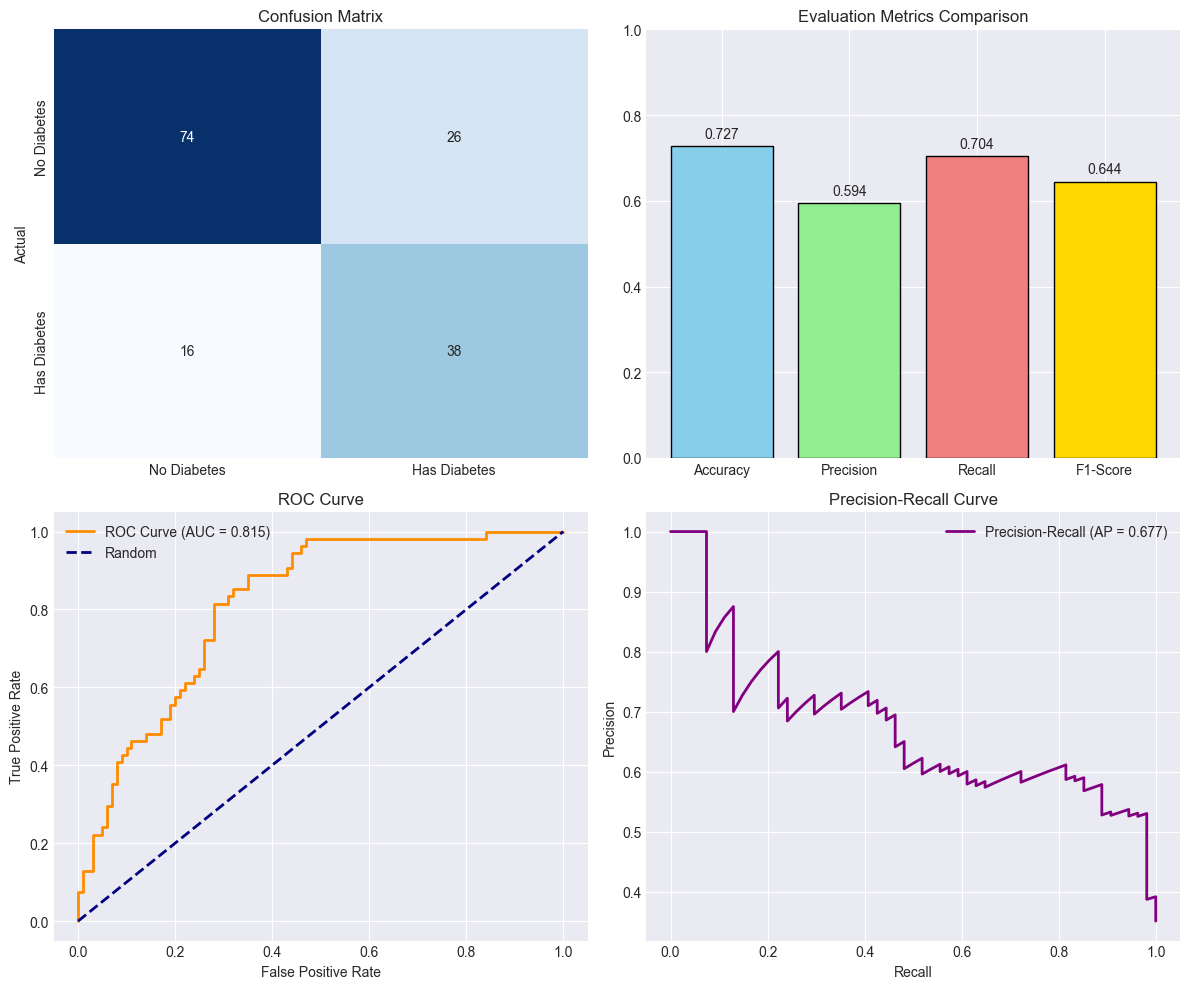

In [10]:
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

# Confusion Matrix
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False, ax=axes[0,0])
axes[0,0].set_ylabel('Actual')
axes[0,0].set_title('Confusion Matrix')
axes[0,0].set_xticklabels(['No Diabetes', 'Has Diabetes'])
axes[0,0].set_yticklabels(['No Diabetes', 'Has Diabetes'])

# Metrics Bar Chart
metrics = ['Accuracy', 'Precision', 'Recall', 'F1-Score']
values = [accuracy, precision, recall, f1]
colors = ['skyblue', 'lightgreen', 'lightcoral', 'gold']
bars = axes[0,1].bar(metrics, values, color=colors, edgecolor='black')
axes[0,1].set_ylim(0, 1)
axes[0,1].set_title('Evaluation Metrics Comparison')
for bar, value in zip(bars, values):
    axes[0,1].text(bar.get_x() + bar.get_width()/2., value + 0.02,
                   f'{value:.3f}', ha='center')

# ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
roc_auc = roc_auc_score(y_test, y_pred_proba)
axes[1,0].plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC Curve (AUC = {roc_auc:.3f})')
axes[1,0].plot([0,1],[0,1], color='navy', lw=2, linestyle='--', label='Random')
axes[1,0].set_xlabel('False Positive Rate')
axes[1,0].set_ylabel('True Positive Rate')
axes[1,0].set_title('ROC Curve')
axes[1,0].legend()

# Precision-Recall Curve
precision_vals, recall_vals, _ = precision_recall_curve(y_test, y_pred_proba)
avg_precision = average_precision_score(y_test, y_pred_proba)
axes[1,1].plot(recall_vals, precision_vals, color='purple', lw=2,
               label=f'Precision-Recall (AP = {avg_precision:.3f})')
axes[1,1].set_xlabel('Recall')
axes[1,1].set_ylabel('Precision')
axes[1,1].set_title('Precision-Recall Curve')
axes[1,1].legend()

plt.tight_layout()
plt.show()



 Feature Importance:
                 Feature  Coefficient
                 Glucose     1.215535
                     BMI     0.728478
             Pregnancies     0.370890
DiabetesPedigreeFunction     0.301328
                     Age     0.176589
                 Insulin    -0.126303
           BloodPressure    -0.023434
           SkinThickness     0.006669


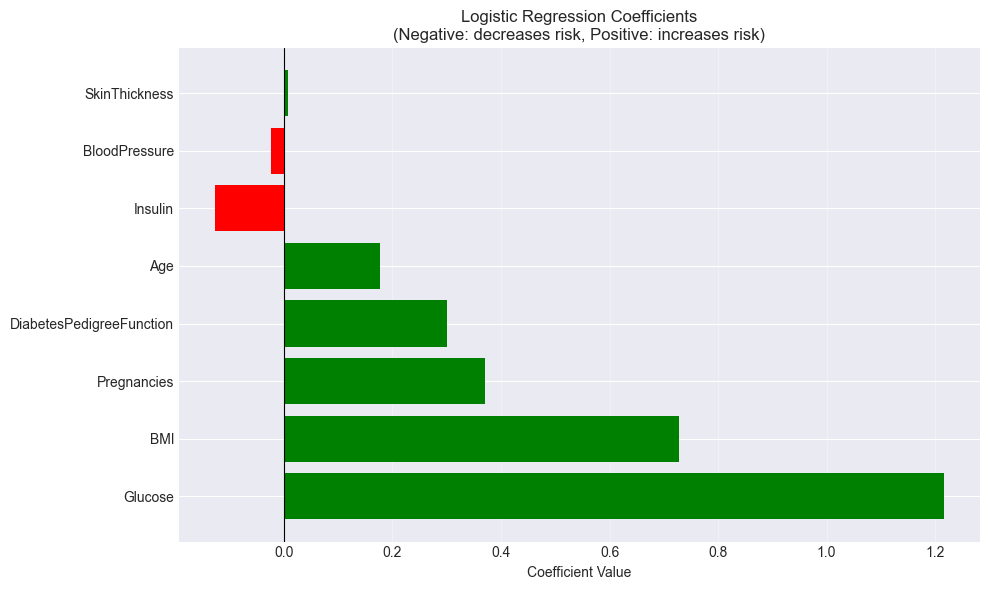

In [11]:
coefficients = pd.DataFrame({
    'Feature': X.columns,
    'Coefficient': model.coef_[0],
    'Abs_Coefficient': np.abs(model.coef_[0])
}).sort_values('Abs_Coefficient', ascending=False)

print("\n Feature Importance:")
print(coefficients.drop('Abs_Coefficient', axis=1).to_string(index=False))

plt.figure(figsize=(10,6))
colors = ['red' if coef < 0 else 'green' for coef in coefficients['Coefficient']]
plt.barh(coefficients['Feature'], coefficients['Coefficient'], color=colors)
plt.axvline(x=0, color='black', linestyle='-', linewidth=0.8)
plt.xlabel('Coefficient Value')
plt.title('Logistic Regression Coefficients\n(Negative: decreases risk, Positive: increases risk)')
plt.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.show()


In [12]:
thresholds = [0.3, 0.4, 0.5, 0.6, 0.7]
print("\nThreshold | Precision | Recall | F1-Score")
print("-" * 40)
for thresh in thresholds:
    y_pred_thresh = (y_pred_proba >= thresh).astype(int)
    p = precision_score(y_test, y_pred_thresh, zero_division=0)
    r = recall_score(y_test, y_pred_thresh)
    f = f1_score(y_test, y_pred_thresh)
    print(f"{thresh:.1f}       | {p:.3f}     | {r:.3f}  | {f:.3f}")



Threshold | Precision | Recall | F1-Score
----------------------------------------
0.3       | 0.552     | 0.889  | 0.681
0.4       | 0.568     | 0.852  | 0.681
0.5       | 0.594     | 0.704  | 0.644
0.6       | 0.604     | 0.593  | 0.598
0.7       | 0.634     | 0.481  | 0.547


In [13]:
print("\n Model Strengths and Weaknesses:")
if recall > 0.7:
    print(f"  • High Recall ({recall:.3f})")
if precision > 0.7:
    print(f"  • High Precision ({precision:.3f})")
if f1 > 0.7:
    print(f"  • Balanced F1-Score ({f1:.3f})")

if fp > fn:
    print(f"  • {fp} False Positives")
if fn > fp:
    print(f"  • {fn} False Negatives")

print("\n Recommendation:")
if recall < precision:
    print("  • Lower the threshold to identify more patients")
else:
    print("  • Increase threshold to reduce false alarms")



 Model Strengths and Weaknesses:
  • High Recall (0.704)
  • 26 False Positives

 Recommendation:
  • Increase threshold to reduce false alarms


In [14]:
summary_df = pd.DataFrame({
    'Metric': ['Accuracy', 'Precision', 'Recall', 'F1-Score', 
               'Specificity', 'NPV', 'ROC-AUC'],
    'Value': [accuracy, precision, recall, f1, specificity, npv, roc_auc],
    'Interpretation': [
        'Overall correctness',
        'Correct positive predictions',
        'Ability to find all positives',
        'Balance of Precision and Recall',
        'Ability to identify negatives',
        'Correct negative predictions',
        'Overall classification ability'
    ]
})
print(summary_df.to_string(index=False))


     Metric    Value                  Interpretation
   Accuracy 0.727273             Overall correctness
  Precision 0.593750    Correct positive predictions
     Recall 0.703704   Ability to find all positives
   F1-Score 0.644068 Balance of Precision and Recall
Specificity 0.740000   Ability to identify negatives
        NPV 0.822222    Correct negative predictions
    ROC-AUC 0.815000  Overall classification ability
